# PoE

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from lightgbm import plot_importance

In [ ]:
# armour: egrep "^[0-9]+\.[0-9]+,[0-9]+\.[0-9]+,[0-9]+\.[0-9]+,[0-9]+\.[0-9]+,[0-9]+\.[0-9]+,[0-9]+\.[0-9]+,1.0"
    
def rename_column(col):
    return col \
        .replace(' ', '_') \
        .replace('.', '_') \
        .replace('\n', '') \
        .replace('\'', '') \
        .replace('\\d+', 'n') \
        .replace('%', 'p')

def process_items():
    items = pd.read_csv('/home/jovyan/work/poe/data-armour-289k.csv')
    armour = items.loc[items['is armour'] == 1]
    armour = armour.drop(['is armour'], axis=1)
    print(armour.shape)
    
    armour_filtered = armour.loc[:, (armour != 0).any(axis=0)]
    armour_filtered = armour_filtered.rename(columns=lambda col: rename_column(col))
    print(armour_filtered.shape)
    
    armour_filtered.to_csv('/home/jovyan/work/poe/data-armour-289k-filtered.csv', index=False)
    
# process_items()

## Price analysis

In [47]:
armour = pd.read_csv('/home/jovyan/work/poe/data-armour-289k-filtered.csv')
armour.shape

(289212, 300)

In [48]:
armour.head()

,price,item_level,num_of_sockets,num_of_linked_sockets,corrupted,Abyss,Map_Tier,Two_Handed_Axe,Bow,Item_Rarity,...,np_Monster_Physical_Damage_Reduction,Craicic_Presence,np_additional_Chance_to_Block_Spells_while_Dual_Wielding,Area_is_inhabited_by_Abominations,np_of_Physical_Damage_from_Hits_taken_as_Fire_Damage,Adds_n_to_n_Cold_Damage_against_Chilled_or_Frozen_Enemies,Adds_n_to_n_Physical_Damage_to_Claw_Attacks,Socketed_Spells_have_np_to_Critical_Strike_Chance,Adds_n_to_n_Physical_Damage_to_Staff_Attacks,Allies_Regenerate_Life
0,14.0,70.0,2.0,1.0,0.0,0.0,29.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,174.0,0.0,0.0
1,4900.0,82.0,0.0,0.0,1.0,0.0,90.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,700.0,78.0,3.0,1.0,0.0,0.0,80.0,0.0,0.0,92.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,234.0,0.0,0.0
3,560.0,72.0,4.0,1.0,0.0,0.0,69.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,331.0,0.0,20.0,0.0
4,14.0,44.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,71.0,0.0,0.0,0.0,0.0


In [171]:
armour.Two_Handed_Axe.describe()

count    289212.000000
mean          0.725444
std           5.689681
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          79.000000
Name: Two_Handed_Axe, dtype: float64

In [154]:
price_bins_ranges = [0, 50, 100, 200, 500]
price_bins = len(price_bins_ranges) - 1

In [155]:
armour.price.describe().apply(lambda x: format(x, 'f'))

count         289212.000000
mean         1900942.652661
std        353669220.374586
min                0.000000
25%               28.000000
50%               70.000000
75%              350.000000
max      69999999300.000000
Name: price, dtype: object

In [156]:
# Filter extreme values.
armour_filtered = armour.loc[(armour.price > 20) & (armour.price < 500)]
armour_filtered.shape

(163035, 300)

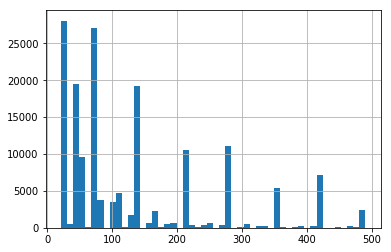

In [166]:
armour_filtered.price.hist(bins=50)

In [157]:
x = armour_filtered.drop(['price'], axis=1)   
y = armour_filtered.price.astype(int)
y_bins = pd.cut(y, bins=price_bins, labels=False)
print(x.shape)
print(y_bins.shape)

(163035, 299)
(163035,)


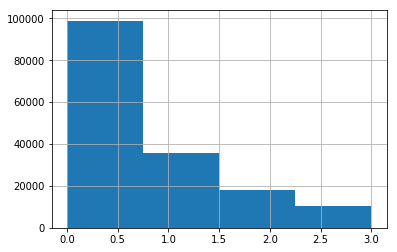

In [158]:
y_bins.hist(bins=price_bins)

## Similarity Matrix

## Clustering

### PCA

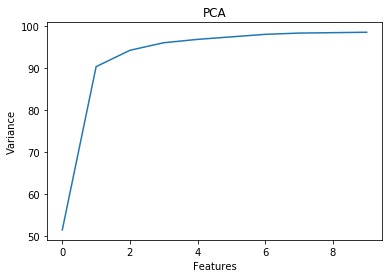

In [159]:
pca = PCA(n_components=10)
pca.fit(x)

variance_pca = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3) * 100)

plt.ylabel('Variance')
plt.xlabel('Features')
plt.title('PCA')

plt.plot(variance_pca)

### LDA

## Prediction

In [162]:
model = LGBMClassifier(boosting='gbdt')
model.fit(x, y_bins)
print("mean accuracy: {}, var accuracy: {}".format(np.mean(cross_val_score(model, x, y_bins, cv=10)),
                                                   np.var(cross_val_score(model, x, y_bins, cv=10))))

mean accuracy: 0.6096298200815193, var accuracy: 1.4598711492454998e-06


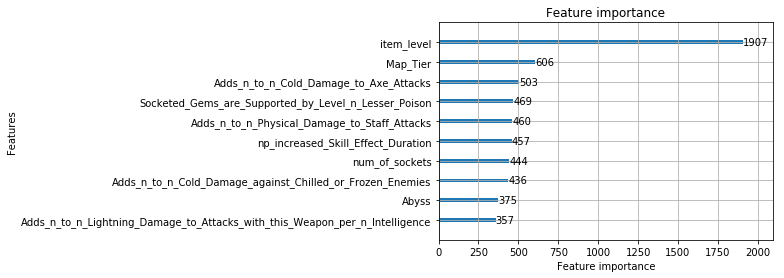

In [163]:
plot_importance(model, max_num_features=10)